# Movie Recommendation using Matrix Factorization

Nipun Batra  
2024-02-06

<figure>
<a
href="https://colab.research.google.com/github/nipunbatra/ml-teaching/blob/master/notebooks/movie-recommendation-knn-mf.ipynb"><img
src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
<figcaption>Open In Colab</figcaption>
</figure>

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [76]:
# Now working with real data

# Load the data

df = pd.read_excel("Movie-Recommendation-2024-Fall.xlsx")
df.head(10)

In [77]:
# Discard the timestamp column

df = df.drop('Timestamp', axis=1)

# Make the "Your Name" column the index

df = df.set_index('Your name')
df

83 rows × 10 columns

In [78]:
df.index

Index(['P.Sai Keerthana ', 'Pradeep ', 'Uday Sankar Gottipalli',
       'Aashmun Gupta', 'Siddharth Mohanty', 'Ayush Shrivastava',
       'Abhay Pisharodi', 'Shreya Mali', 'Shounak Ranade',
       'Prathamesh P. Shanbhag', 'Suruchi Hardaha', 'Balkrishna Sehra',
       'Het Shukla', 'N. Eshwar karthikeya ', 'Dhruv Patel',
       'Shreyas Dharmatti ', 'Mohit', 'Praveen Rathod ', 'Dinesh', 'Rahul',
       'Devansh Lodha', 'Abhinav ', 'Tejas Lohia', 'Laksh Jain ',
       'Burra Saharsh', 'Vanshri', 'Karan Gandhi', 'Romit Mohane ',
       'Vedant Acharya', 'Abhiroop Chintalapudi', 'Yash sahu', 'Dinesh',
       'Manish Prasad', 'Parthiv', 'Shivansh Soni',
       'Chepuri Venkata Naga Thrisha', 'Abhinav Kumar', 'Anurag',
       'Bhavya Parmar ', 'Soham Shrivastava ', 'Aditya Borate', 'Hemant ',
       'Abhinav Singh Yadav ', 'Arul Singh', 'Harinarayan J ',
       'uday kumar jarapala', 'Sailesh Panda', 'Yash Sonone ', 'Sayak Dutta',
       'Biswajit Rakshit', 'Praanshu ', 'Samarth Sonawane ',

In [79]:
# Get index for user and movie
user = 'Ayush Shrivastava'

print(user in df.index)

# Get the movie ratings for user
user_ratings = df.loc[user]
user_ratings

True

Sholay                      4.0
Swades (We The People)      4.0
The Matrix (I)              5.0
Interstellar                5.0
Dangal                      3.0
Taare Zameen Par            4.0
Shawshank Redemption        NaN
The Dark Knight             NaN
Notting Hill                NaN
Uri: The Surgical Strike    4.0
Name: Ayush Shrivastava, dtype: float64

In [80]:
# Number of missing values
df.isnull().sum()

Sholay                      20
Swades (We The People)      35
The Matrix (I)               6
Interstellar                14
Dangal                       4
Taare Zameen Par             8
Shawshank Redemption        35
The Dark Knight             25
Notting Hill                45
Uri: The Surgical Strike    12
dtype: int64

In [81]:
# Generic Matrix Factorization (without missing values)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

n_users, n_movies = 20, 10

# A is a matrix of size (n_users, n_movies) randomly generated values between 1 and 5
A = torch.randint(1, 6, (n_users, n_movies), dtype=torch.float)
A

tensor([[3., 5., 1., 2., 2., 5., 1., 5., 5., 3.],
        [1., 5., 4., 4., 5., 5., 5., 1., 4., 2.],
        [3., 3., 5., 1., 1., 5., 5., 1., 1., 2.],
        [4., 3., 2., 2., 5., 4., 4., 5., 2., 1.],
        [4., 1., 1., 5., 4., 2., 2., 4., 3., 1.],
        [4., 2., 5., 4., 3., 5., 5., 3., 4., 3.],
        [1., 3., 1., 3., 1., 3., 5., 4., 1., 2.],
        [1., 1., 2., 4., 3., 3., 2., 1., 5., 1.],
        [3., 1., 1., 1., 5., 4., 2., 5., 5., 2.],
        [2., 2., 1., 5., 3., 5., 3., 2., 1., 4.],
        [3., 3., 3., 4., 4., 1., 5., 3., 4., 4.],
        [5., 1., 1., 3., 2., 2., 4., 5., 2., 3.],
        [3., 1., 4., 1., 1., 3., 3., 3., 1., 2.],
        [1., 5., 1., 3., 3., 4., 1., 4., 2., 3.],
        [1., 2., 1., 3., 5., 4., 4., 1., 3., 3.],
        [3., 4., 3., 4., 4., 2., 2., 5., 4., 2.],
        [1., 4., 4., 4., 4., 1., 3., 5., 2., 3.],
        [1., 5., 4., 3., 3., 2., 3., 2., 3., 4.],
        [5., 4., 2., 3., 2., 4., 5., 2., 1., 1.],
        [4., 4., 2., 1., 2., 3., 4., 1., 4., 4.]])

In [82]:
A.shape

torch.Size([20, 10])

Let us decompose A as WH. W is of shape (n, k) and H is of shape (k, n).
We can write the above equation as: A = WH

In [93]:
# Randomly initialize A and B

# Set device to cuda:0 if available and on Linux
# If on mac try mps
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Working on device: ", device)
r = 3
W = torch.randn(n_users, r, requires_grad=True, device=device)
H = torch.randn(r, n_movies, requires_grad=True, device=device)

A = A.to(device)

# Compute the loss
with torch.no_grad():
    loss = torch.norm(torch.mm(W, H) - A)
    print(loss)

Working on device:  mps
tensor(50.2602, device='mps:0')

In [99]:
with torch.no_grad():
    temp_pred = torch.mm(W, H)
    bw_0_1 = torch.nn.Sigmoid()(temp_pred)
    bw_0_5 = 5*bw_0_1
print(temp_pred.max(), temp_pred.min())
print(bw_0_1.max(), bw_0_1.min())
print(bw_0_5.max(), bw_0_5.min())

tensor(4.2534, device='mps:0') tensor(-6.2291, device='mps:0')
tensor(0.9860, device='mps:0') tensor(0.0020, device='mps:0')
tensor(4.9299, device='mps:0') tensor(0.0098, device='mps:0')

In [84]:
pd.DataFrame(torch.mm(W, H).cpu().detach().numpy()).head()

In [16]:
pd.DataFrame(A.cpu().detach().numpy()).head()

In [85]:
# Optimizer
optimizer = optim.Adam([W, H], lr=0.01)

# Train the model

for i in range(600):
    # Compute the loss
    loss = torch.norm(torch.mm(W, H) - A)
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Backpropagate
    loss.backward()
    
    # Update the parameters
    optimizer.step()
    
    # Print the loss
    if i % 10 == 0:
        print(i, loss.item())

0 55.518882751464844
10 52.659767150878906
20 50.37566375732422
30 48.51186752319336
40 46.83131790161133
50 45.094539642333984
60 43.114288330078125
70 40.78749084472656
80 38.10878372192383
90 35.157928466796875
100 32.074623107910156
110 29.021379470825195
120 26.15049934387207
130 23.621992111206055
140 21.566579818725586
150 20.013381958007812
160 18.89710235595703
170 18.127681732177734
180 17.621126174926758
190 17.2957820892334
200 17.079294204711914
210 16.919897079467773
220 16.787397384643555
230 16.666202545166016
240 16.548551559448242
250 16.430585861206055
260 16.310630798339844
270 16.188627243041992
280 16.06583595275879
290 15.944452285766602
300 15.82705020904541
310 15.71599006652832
320 15.612943649291992
330 15.518715858459473
340 15.433331489562988
350 15.356307983398438
360 15.286922454833984
370 15.224400520324707
380 15.168001174926758
390 15.117039680480957
400 15.070890426635742
410 15.028966903686523
420 14.990720748901367
430 14.955638885498047
440 14.9232

In [86]:
pd.DataFrame(torch.mm(W, H).cpu().detach().numpy()).head(2)

In [90]:
with torch.no_grad():
    pred = torch.mm(W, H)
print(pred)

tensor([[2.5071, 2.8824, 1.0148, 3.6180, 4.3937, 4.2447, 2.5265, 3.7592, 4.1760,
         2.4725],
        [2.0962, 4.7191, 3.4037, 3.5383, 3.7275, 5.8259, 4.7976, 1.2867, 3.5560,
         3.3190],
        [1.9424, 3.8889, 4.4717, 2.1537, 1.5326, 3.5554, 4.9624, 0.3696, 1.3432,
         2.7223],
        [3.2004, 2.8246, 2.0544, 3.4926, 3.8315, 3.3191, 3.2242, 4.3713, 3.5237,
         2.6092],
        [3.1014, 1.7170, 0.8792, 3.1483, 3.6712, 2.1976, 1.9481, 5.0449, 3.3680,
         1.9746],
        [3.4649, 4.0731, 3.9972, 3.6500, 3.5021, 4.1153, 5.0495, 3.4916, 3.1635,
         3.3433],
        [2.4187, 2.5760, 2.6503, 2.4030, 2.2778, 2.4943, 3.3048, 2.5503, 2.0379,
         2.1813],
        [1.4519, 2.4073, 0.8205, 2.5799, 3.1635, 3.6162, 1.9812, 1.9655, 3.0497,
         1.8606],
        [2.9072, 2.0137, 0.5374, 3.4440, 4.2075, 2.9997, 1.8686, 4.8841, 3.9363,
         2.1061],
        [1.8149, 3.1825, 1.7480, 2.9721, 3.4117, 4.3003, 2.9872, 1.9706, 3.2621,
         2.3937],
        [3

In [92]:
pred.max(), pred.min()

(tensor(5.8259, device='mps:0'), tensor(0.3696, device='mps:0'))

In [87]:
pd.DataFrame(A.cpu()).head(2)

In [100]:
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix A into W and H
    A: input matrix of size (n_users, n_movies)
    k: number of latent features
    
    Returns W and H
    W: matrix of size (n_users, k)
    H: matrix of size (k, n_movies)
    """
    A = A.to(device)
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    
    # Train the model
    for i in range(1000):
        # Compute the loss
        loss = torch.norm(torch.mm(W, H) - A)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [101]:
for k in [1, 2, 3, 4, 5, 6, 9]:
    W, H, loss = factorize(A, k, device=device)
    print(k, loss.item())

1 18.47580909729004
2 16.0474853515625
3 13.883170127868652
4 12.110709190368652
5 10.14443302154541
6 8.560541152954102
9 3.077495813369751

In [102]:
pd.DataFrame(torch.mm(W,H).cpu().detach().numpy()).head(2)

In [103]:
pd.DataFrame(A.cpu()).head(2)

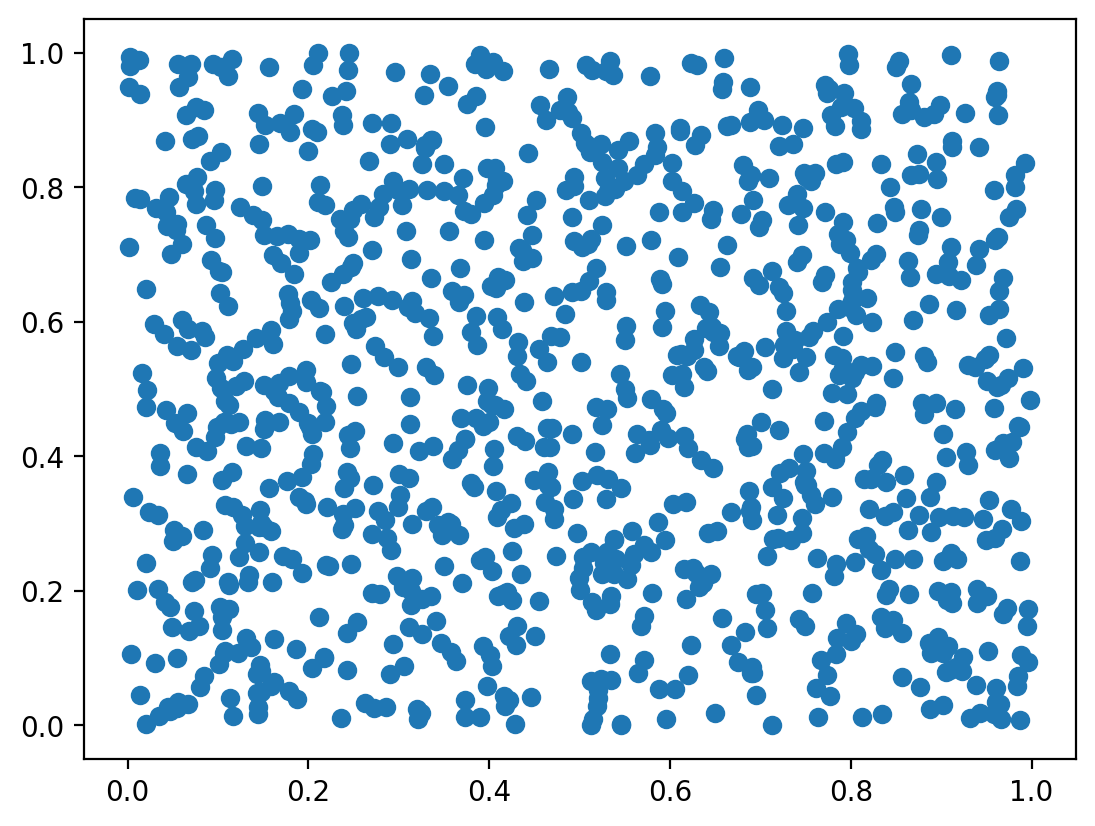

In [68]:
x_uniform2d = torch.rand(1000, 2)
# satter plot
plt.scatter(x_uniform2d[:, 0], x_uniform2d[:, 1])

In [69]:
# Check values of x_uniform2d < 0.5 and color them red
mask = x_uniform2d < 0.5
print(mask)

tensor([[ True,  True],
        [ True,  True],
        [ True,  True],
        ...,
        [ True,  True],
        [False,  True],
        [False,  True]])

In [115]:
# With missing values

# Randomly replace some entries with NaN

A = torch.randint(1, 6, (n_users, n_movies), dtype=torch.float)
A[torch.rand(A.shape) < 0.5] = float('nan')
A

tensor([[5., nan, nan, nan, 3., nan, nan, nan, 2., nan],
        [nan, nan, 1., nan, 1., nan, nan, 3., 5., 1.],
        [3., nan, nan, nan, 4., 1., nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, 5., 5., nan, 3., nan],
        [2., 3., nan, 2., 1., nan, nan, 1., 1., nan],
        [nan, 4., nan, 3., 5., nan, 3., 4., 2., 2.],
        [nan, nan, nan, nan, nan, 2., 1., 5., 2., nan],
        [5., 5., nan, nan, 1., nan, nan, nan, 4., 4.],
        [nan, nan, nan, nan, 3., nan, nan, nan, 2., 4.],
        [nan, nan, nan, nan, nan, 3., 2., 3., 5., 5.],
        [nan, 4., nan, nan, 2., nan, 2., nan, nan, nan],
        [nan, 2., 3., nan, 4., nan, nan, 4., nan, 2.],
        [nan, nan, 2., 2., 4., 2., 2., 3., nan, nan],
        [3., nan, 1., nan, nan, 3., nan, nan, 1., nan],
        [nan, 2., nan, nan, 5., nan, nan, 2., 1., nan],
        [nan, 2., nan, nan, 5., nan, 4., nan, nan, 1.],
        [nan, nan, nan, nan, 1., 3., 2., 3., 1., nan],
        [nan, nan, nan, 3., nan, nan, nan, 3., 4., 1.],

In [116]:
W, H, loss = factorize(A, 2, device=device)
loss

tensor(nan, device='mps:0', grad_fn=<NormBackward1>)

As expected, the above function does not work. Our current loss function
does not handle missing values.

In [117]:
A.shape

torch.Size([20, 10])

In [118]:
mask = ~torch.isnan(A)
mask

tensor([[ True, False, False, False,  True, False, False, False,  True, False],
        [False, False,  True, False,  True, False, False,  True,  True,  True],
        [ True, False, False, False,  True,  True, False, False, False, False],
        [False, False, False, False, False,  True,  True, False,  True, False],
        [ True,  True, False,  True,  True, False, False,  True,  True, False],
        [False,  True, False,  True,  True, False,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True, False],
        [ True,  True, False, False,  True, False, False, False,  True,  True],
        [False, False, False, False,  True, False, False, False,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False,  True, False, False,  True, False,  True, False, False, False],
        [False,  True,  True, False,  True, False, False,  True, False,  True],
        [False, False,  True,  True,  Tr

In [119]:
mask.sum()

tensor(87)

In [120]:
W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
H = torch.randn(k, A.shape[1],  requires_grad=True, device=device)

diff_matrix = torch.mm(W, H)-A.to(device)
diff_matrix.shape

torch.Size([20, 10])

In [121]:
diff_matrix

tensor([[-6.9854,     nan,     nan,     nan,  2.5382,     nan,     nan,     nan,
         -3.3296,     nan],
        [    nan,     nan, -4.0131,     nan, -6.2010,     nan,     nan, -3.9650,
         -6.5180,  0.9829],
        [-1.0404,     nan,     nan,     nan, -4.7079, -0.7452,     nan,     nan,
             nan,     nan],
        [    nan,     nan,     nan,     nan,     nan, -6.6035, -6.2113,     nan,
         -5.2806,     nan],
        [ 2.2240, -0.5113,     nan, -1.0281, -0.3319,     nan,     nan, -1.0290,
         -8.5193,     nan],
        [    nan, -1.5060,     nan, -1.0225, -5.9332,     nan,  3.1254, -1.2558,
         -7.6531, -1.3446],
        [    nan,     nan,     nan,     nan,     nan, -1.1617,  1.4732, -4.9664,
         -6.6226,     nan],
        [-2.9062, -4.3373,     nan,     nan, -3.4020,     nan,     nan,     nan,
         -7.5088, -4.6871],
        [    nan,     nan,     nan,     nan, -6.3027,     nan,     nan,     nan,
         -6.2829, -4.3568],
        [    nan,  

In [122]:
# Mask the matrix
diff_matrix[mask].shape

torch.Size([87])

In [123]:
diff_matrix[mask]

tensor([-6.9854,  2.5382, -3.3296, -4.0131, -6.2010, -3.9650, -6.5180,  0.9829,
        -1.0404, -4.7079, -0.7452, -6.6035, -6.2113, -5.2806,  2.2240, -0.5113,
        -1.0281, -0.3319, -1.0290, -8.5193, -1.5060, -1.0225, -5.9332,  3.1254,
        -1.2558, -7.6531, -1.3446, -1.1617,  1.4732, -4.9664, -6.6226, -2.9062,
        -4.3373, -3.4020, -7.5088, -4.6871, -6.3027, -6.2829, -4.3568, -0.5816,
        -1.3435, -6.3993, -5.6600, -4.1959, -7.8034,  0.4608, -5.6186, -6.6628,
         1.1697, -3.5552, -8.1775,  2.9435, -1.3904, -2.1634,  6.3728, -1.6834,
         0.0504, -3.1274, -1.1221,  1.2635, -3.3154, -5.8986, -2.8094, -5.0974,
        -2.7950, -6.6121, -3.9005, -7.2914, -5.1783, -0.4819, -4.6136,  0.8440,
         0.9016,  1.4004, -7.1846, -2.3378,  0.4268, -9.2480, -0.9357, -5.5819,
         2.4075, -3.1272,  3.5693, -0.1390,  4.1499, -2.5375, -4.0199],
       device='mps:0', grad_fn=<IndexBackward0>)

In [161]:
# Modify the loss function to ignore NaN values

def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        #diff_matrix = 5*torch.nn.Sigmoid()(torch.mm(W, H)) - A
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [138]:
W, H, loss = factorize(A, 5, device=device)
loss

tensor(8.0831, device='mps:0', grad_fn=<NormBackward1>)

In [139]:
torch.mm(W, H)

tensor([[ 3.7077e-01,  6.6310e+00,  1.5317e+01,  1.5463e+00,  2.3812e+00,
          1.0566e+01,  4.1666e-01,  3.7488e-01,  1.9886e+01,  9.1443e+00],
        [ 6.0725e+00,  4.9374e+00,  1.1223e+01,  1.6064e+01,  5.0131e+00,
          7.6977e+00,  1.3872e+00,  8.5424e+00,  4.0570e-01,  8.0806e+00],
        [ 4.0886e-01,  4.3280e-01,  3.1149e+01,  1.4252e+01,  3.7623e+00,
          6.6555e+00,  2.3225e+01,  2.7410e+01,  5.6219e+00,  1.3889e+00],
        [ 1.4532e+00,  1.7891e+00,  1.3172e+00,  3.0270e+00,  1.1199e+00,
          2.3014e+00, -1.2625e+00,  3.5530e-01,  1.5922e+00,  2.7375e+00],
        [ 1.6632e+00,  2.6585e-01,  2.1361e+01,  7.0106e+00,  2.8000e+00,
          3.5102e+00,  4.2856e-01,  3.3931e+00, -3.8024e-01,  1.5930e+00],
        [ 1.2141e+00,  1.0140e+00,  3.0760e+00,  2.6695e+00,  1.0877e+00,
          1.3464e+00, -8.1209e+00, -2.7409e+00,  9.0885e-01,  2.8838e+00],
        [ 4.0901e-01,  3.9038e+00,  8.7977e+00,  4.1466e-01,  1.3196e+00,
          6.3608e+00,  6.7289e+0

In [140]:
df.values.shape

(83, 10)

In [141]:
A = torch.tensor(df.values, dtype=torch.float)
W, H, loss = factorize(A, 3, device=device)
print(loss)

tensor(13.0500, device='mps:0', grad_fn=<NormBackward1>)

In [145]:
# Dropdown menu for user and predict for all movies
from ipywidgets import interact, widgets



def predict_movie_ratings(user, df, W, H):
    idx = df.index.get_loc(user)
    user_ratings = df.iloc[idx]
    user_ratings = user_ratings.dropna()
    user_ratings = user_ratings.to_frame().T
    user_ratings = user_ratings.reindex(columns=df.columns, fill_value=float('nan'))
    user_ratings = user_ratings.to_numpy()
    
    predicted_ratings = 5*torch.nn.Sigmoid()(torch.mm(W, H)).cpu().detach().numpy()
    return pd.DataFrame({"Observed": user_ratings.flatten(), "Predicted": predicted_ratings[idx].flatten()}, index=df.columns)


In [146]:
predict_movie_ratings('Ayush Shrivastava', df, W, H)

In [147]:
interact(predict_movie_ratings, user=widgets.Dropdown(options=df.index, value=df.index[0], description='User'), df=widgets.fixed(df), W=widgets.fixed(W), H=widgets.fixed(H))

<function __main__.predict_movie_ratings(user, df, W, H)>

In [148]:
# Image completion
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists

In [149]:
# Read in a image from torchvision
import torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])

In [150]:
# Make grayscale
img = torch.tensor(img, dtype=torch.float)
img = img.mean(dim=0, keepdim=False)
print(img.shape)

torch.Size([1365, 2048])

In [151]:
img.shape

torch.Size([1365, 2048])

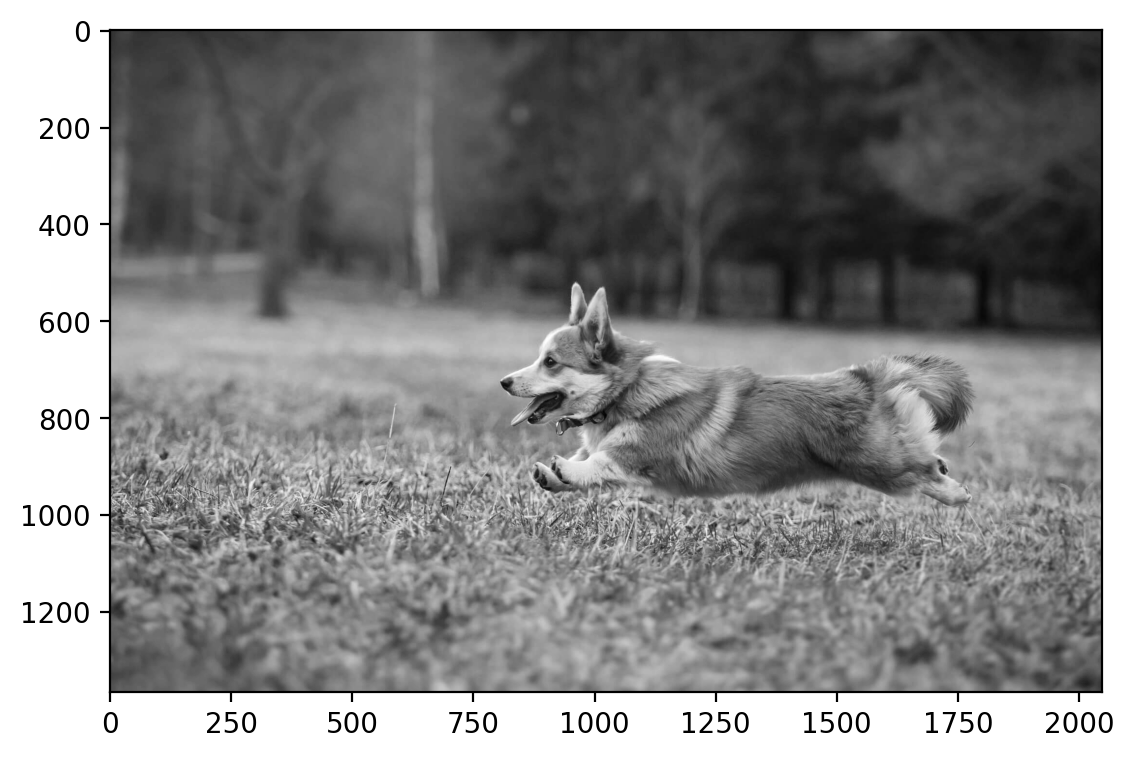

In [152]:
plt.imshow(img, cmap='gray')

In [153]:
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
crop.shape

torch.Size([300, 300])

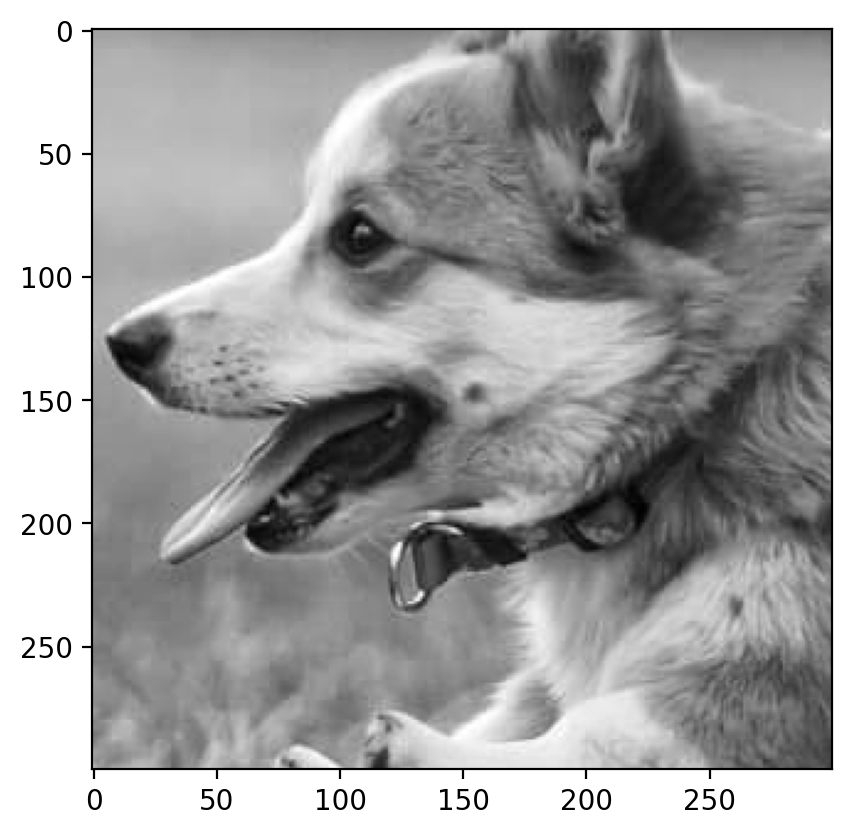

In [56]:
plt.imshow(crop, cmap='gray')

In [154]:
# Mask the image with NaN values 
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

In [155]:
masked_img = mask_image(crop, 0.3)


In [156]:
masked_img[1].sum()

tensor(26858)

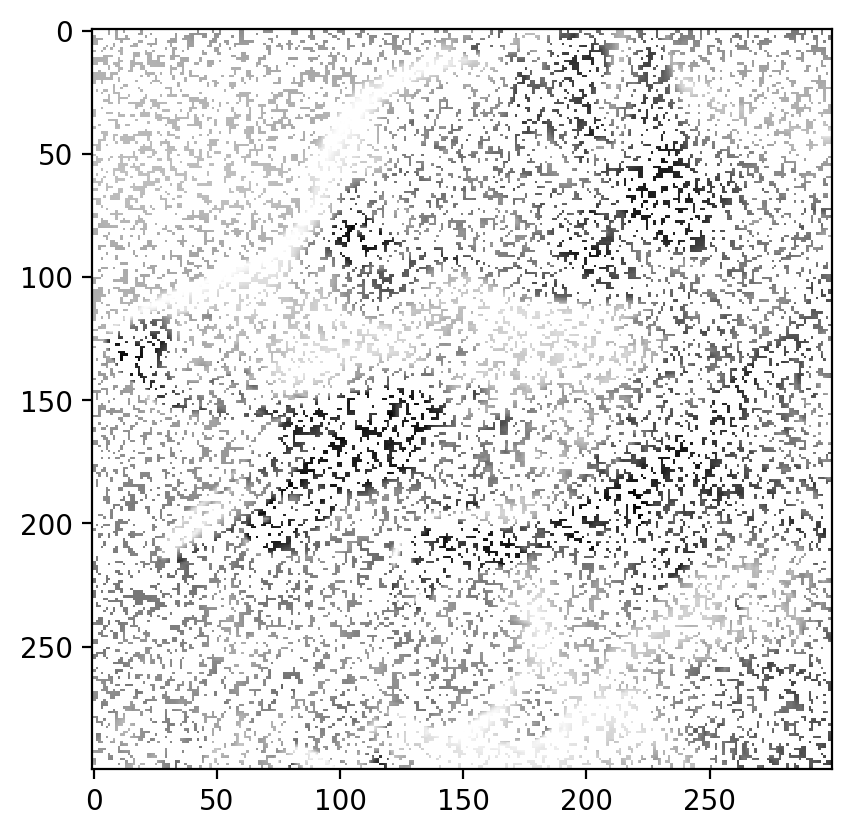

In [157]:
plt.imshow(masked_img[0], cmap='gray')

In [162]:
W, H, loss = factorize(masked_img[0], 50, device=device)

In [163]:
loss

tensor(1303.8575, device='mps:0', grad_fn=<NormBackward1>)

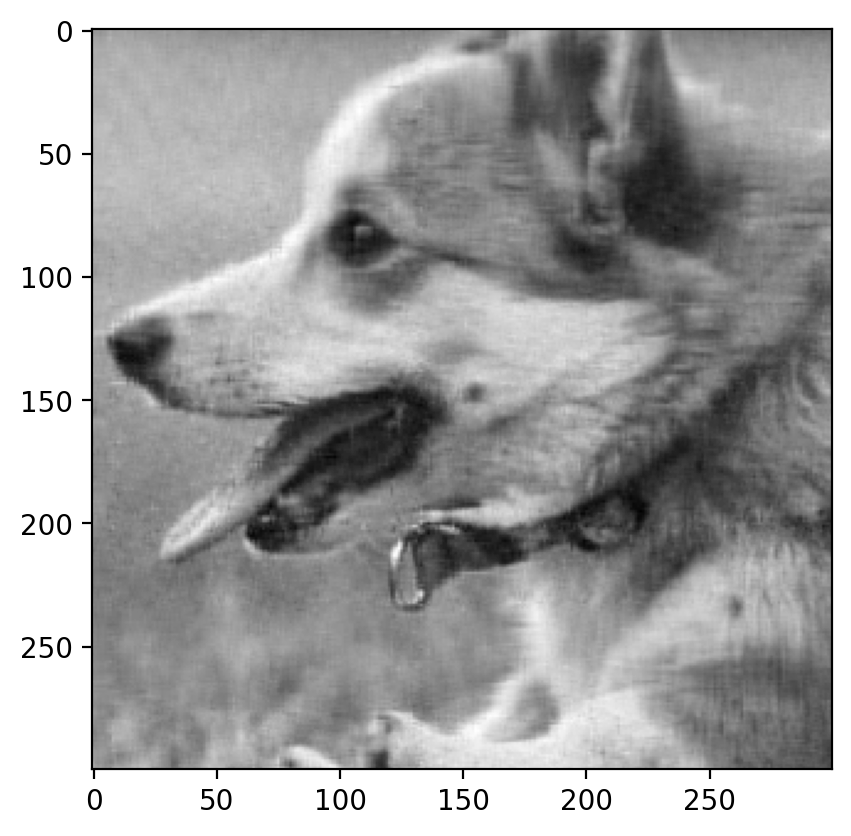

In [164]:
plt.imshow(torch.mm(W, H).cpu().detach().numpy(), cmap='gray')

In [165]:
def plot_image_completion(prop=0.1, factors=50):
    masked_img, mask = mask_image(crop, prop)
    W, H, loss = factorize(masked_img, factors, device=device)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    reconstructed_img = torch.mm(W, H).cpu().detach().numpy()
    ax[0].imshow(masked_img, cmap='gray')
    ax[0].set_title("Masked image")
    ax[1].imshow(reconstructed_img, cmap='gray')
    ax[1].set_title("Reconstructed image")

In [166]:
interact(plot_image_completion, prop=widgets.FloatSlider(min=0.01, max=0.9, step=0.01, value=0.3), factors=widgets.IntSlider(min=1, max=150, step=1, value=50))

<function __main__.plot_image_completion(prop=0.1, factors=50)>

In [45]:
# Now use matrix faactaorization to predict the ratings

import torch
import torch.nn as nn
import torch.nn.functional as F

# Create a class for the model

class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_movies, n_factors=20):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.movie_factors = nn.Embedding(n_movies, n_factors)

    def forward(self, user, movie):
        return (self.user_factors(user) * self.movie_factors(movie)).sum(1)      